In [1]:
!pip install opencv-python mediapipe
import matplotlib.pyplot as plt

import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
import math
import cv2
from time import time
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
import os
import cv2
import mediapipe as mp
import glob
import pandas as pd
import argparse
import numpy as np
import math

# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--dataset", type=str, required=True,
#                 help="yoga/train/tree")

# ap.add_argument("-o", "--save", type=str, required=True,
#                 help="train_data.csv")

# args = vars(ap.parse_args())

path_data_dir = "dataset/train"
path_to_save = "train_data_final_angle.csv"

##############
torso_size_multiplier = 2.5
n_landmarks = 33
n_dimensions = 3
landmark_names = [
    'nose',
    'left_eye_inner', 'left_eye', 'left_eye_outer',
    'right_eye_inner', 'right_eye', 'right_eye_outer',
    'left_ear', 'right_ear',
    'mouth_left', 'mouth_right',
    'left_shoulder', 'right_shoulder',
    'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist',
    'left_pinky_1', 'right_pinky_1',
    'left_index_1', 'right_index_1',
    'left_thumb_2', 'right_thumb_2',
    'left_hip', 'right_hip',
    'left_knee', 'right_knee',
    'left_ankle', 'right_ankle',
    'left_heel', 'right_heel',
    'left_foot_index', 'right_foot_index',
]
##############

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5,min_tracking_confidence=0.5, model_complexity=2)

class_list = os.listdir(path_data_dir)
class_list = sorted(class_list)

col_names = []
for i in range(n_landmarks):
    name = mp_pose.PoseLandmark(i).name
    name_x = name + '_X'
    name_y = name + '_Y'
    name_z = name + '_Z'
    name_v = name + '_V'
    col_names.append(name_x)
    col_names.append(name_y)
    col_names.append(name_z)
    col_names.append(name_v)

full_lm_list = []
target_list = []
for class_name in class_list:
    path_to_class = os.path.join(path_data_dir, class_name)
    img_list = glob.glob(path_to_class + '/*.jpg') + \
        glob.glob(path_to_class + '/*.jpeg') + \
        glob.glob(path_to_class + '/*.png')
    img_list = sorted(img_list)

    # Read reach Images in the each classes
    for img in img_list:
        image = cv2.imread(img)
        h, w, c = image.shape
        if image is None:
            print(
                f'[ERROR] Error in reading {img} -- Skipping.....\n[INFO] Taking next Image')
            continue
        else:
            img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            result = pose.process(img_rgb)
            if result.pose_landmarks:
                lm_list = []
                for landmarks in result.pose_landmarks.landmark:
                    # Preprocessing
                    max_distance = 0
                    lm_list.append(landmarks)
                center_x = (lm_list[landmark_names.index('right_hip')].x +
                            lm_list[landmark_names.index('left_hip')].x)*0.5
                center_y = (lm_list[landmark_names.index('right_hip')].y +
                            lm_list[landmark_names.index('left_hip')].y)*0.5

                shoulders_x = (lm_list[landmark_names.index('right_shoulder')].x +
                               lm_list[landmark_names.index('left_shoulder')].x)*0.5
                shoulders_y = (lm_list[landmark_names.index('right_shoulder')].y +
                               lm_list[landmark_names.index('left_shoulder')].y)*0.5

                for lm in lm_list:
                    distance = math.sqrt(
                        (lm.x - center_x)**2 + (lm.y - center_y)**2)
                    if(distance > max_distance):
                        max_distance = distance
                torso_size = math.sqrt(
                    (shoulders_x - center_x)**2 + (shoulders_y - center_y)**2)
                max_distance = max(
                    torso_size*torso_size_multiplier, max_distance)

                pre_lm = list(np.array([[(landmark.x-center_x)/max_distance, (landmark.y-center_y)/max_distance,
                              landmark.z/max_distance, landmark.visibility] for landmark in lm_list]).flatten())

                full_lm_list.append(pre_lm)
                target_list.append(class_name)

            print(f'{os.path.split(img)[1]} Landmarks added Successfully')
    print(f'[INFO] {class_name} Successfully Completed')

print('[INFO] Landmarks from Dataset Successfully Completed')

data_x = pd.DataFrame(full_lm_list, columns=col_names)
data = data_x.assign(Pose_Class=target_list)
data.to_csv(path_to_save, encoding='utf-8', index=False)
print(f'[INFO] Successfully Saved Landmarks data into {path_to_save}')

# def calculateAngle(landmark1, landmark2, landmark3):
#     x1, y1, _ = landmark1
#     x2, y2, _ = landmark2
#     x3, y3, _ = landmark3

#     angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))

#     if angle < 0:
#         angle += 360

#     return angle

# angle_col_names = []
# for i in range(n_landmarks - 2):
#     angle_name = f'Angle_{i}'
#     angle_col_names.append(angle_name)

# angle_list = []
# for lm in full_lm_list:
#     angles = []
#     for i in range(0, len(lm), n_dimensions):
#         if i < len(lm) - 2 * n_dimensions:
#             angle = calculateAngle(
#                 lm[i:i + n_dimensions], lm[i + n_dimensions:i + 2 * n_dimensions], lm[i + 2 * n_dimensions:i + 3 * n_dimensions])
#             angles.append(angle)
#     angle_list.append(angles)
# data_angle = pd.DataFrame(angle_list, columns=42)
# data_angle.to_csv('data_angle.csv', encoding='utf-8', index=False)
# print(f'[INFO] Successfully Saved Angle data into data_angle.csv')

# data_x_with_angles = data_x.assign(**dict(zip(angle_col_names, np.array(angle_list))))
# data_with_angles = data_x_with_angles.assign(Pose_Class=target_list)
# data_with_angles.to_csv(path_to_save, encoding='utf-8', index=False)
# print(f'[INFO] Successfully Saved Landmarks data with angles into {path_to_save}')

00000128.jpg Landmarks added Successfully
00000130.jpg Landmarks added Successfully
00000131.jpg Landmarks added Successfully
00000132.png Landmarks added Successfully
00000133.jpg Landmarks added Successfully
00000137(1).jpg Landmarks added Successfully
00000137.jpg Landmarks added Successfully
00000138.jpg Landmarks added Successfully
00000139.jpg Landmarks added Successfully
00000140.jpg Landmarks added Successfully
00000142.jpg Landmarks added Successfully
00000143.jpg Landmarks added Successfully
00000144.jpg Landmarks added Successfully
00000145.jpg Landmarks added Successfully
00000146.jpg Landmarks added Successfully
00000147.jpg Landmarks added Successfully
00000150.jpg Landmarks added Successfully
00000151.jpg Landmarks added Successfully
00000154.jpg Landmarks added Successfully
00000155.jpg Landmarks added Successfully
00000158.jpg Landmarks added Successfully
00000160.jpg Landmarks added Successfully
00000161.jpg Landmarks added Successfully
00000162.jpg Landmarks added Su

00000123.png Landmarks added Successfully
00000124.jpg Landmarks added Successfully
00000126.JPG Landmarks added Successfully
00000129.jpg Landmarks added Successfully
00000130.jpg Landmarks added Successfully
00000134.jpg Landmarks added Successfully
00000136.jpg Landmarks added Successfully
00000137.jpg Landmarks added Successfully
00000145.jpg Landmarks added Successfully
00000149.jpg Landmarks added Successfully
00000150.jpg Landmarks added Successfully
00000154.jpg Landmarks added Successfully
00000157.png Landmarks added Successfully
00000160.jpg Landmarks added Successfully
00000163.jpg Landmarks added Successfully
00000164.jpg Landmarks added Successfully
00000165.jpg Landmarks added Successfully
00000171.jpg Landmarks added Successfully
00000172.jpg Landmarks added Successfully
00000173.jpg Landmarks added Successfully
00000176.jpg Landmarks added Successfully
00000177.jpg Landmarks added Successfully
00000178.jpg Landmarks added Successfully
00000181.jpg Landmarks added Succe

00000289.jpg Landmarks added Successfully
00000290.png Landmarks added Successfully
00000291.jpg Landmarks added Successfully
00000292.jpg Landmarks added Successfully
00000293.jpg Landmarks added Successfully
00000294.png Landmarks added Successfully
00000295.jpg Landmarks added Successfully
00000296.jpg Landmarks added Successfully
00000297.jpg Landmarks added Successfully
00000299.jpg Landmarks added Successfully
00000302.jpg Landmarks added Successfully
00000303.jpg Landmarks added Successfully
00000304.jpg Landmarks added Successfully
00000305.jpg Landmarks added Successfully
00000306.jpg Landmarks added Successfully
00000307.png Landmarks added Successfully
00000308.jpg Landmarks added Successfully
00000309.jpg Landmarks added Successfully
00000310.jpg Landmarks added Successfully
00000312.jpg Landmarks added Successfully
00000313.jpg Landmarks added Successfully
00000314.jpg Landmarks added Successfully
00000316.jpg Landmarks added Successfully
00000317.jpg Landmarks added Succe

File11.jpg Landmarks added Successfully
File12.jpg Landmarks added Successfully
File13.jpg Landmarks added Successfully
File14.jpg Landmarks added Successfully
File17.jpg Landmarks added Successfully
File18.jpg Landmarks added Successfully
File25.jpg Landmarks added Successfully
File31.jpg Landmarks added Successfully
File36.jpg Landmarks added Successfully
File38.jpg Landmarks added Successfully
File40.jpg Landmarks added Successfully
File41.jpg Landmarks added Successfully
File42.jpg Landmarks added Successfully
File47.jpg Landmarks added Successfully
File49.jpg Landmarks added Successfully
File55.jpg Landmarks added Successfully
File64.jpg Landmarks added Successfully
File66.jpg Landmarks added Successfully
File72.jpg Landmarks added Successfully
File73.jpg Landmarks added Successfully
File81.jpg Landmarks added Successfully
File84.jpg Landmarks added Successfully
[INFO] tree Successfully Completed
00000118.jpg Landmarks added Successfully
00000121.jpg Landmarks added Successfully
0

00000401.jpg Landmarks added Successfully
00000402.jpg Landmarks added Successfully
00000406.jpg Landmarks added Successfully
00000407.jpg Landmarks added Successfully
00000408.jpg Landmarks added Successfully
00000410.jpg Landmarks added Successfully
00000414.jpg Landmarks added Successfully
00000416.png Landmarks added Successfully
00000419.jpg Landmarks added Successfully
00000420.jpg Landmarks added Successfully
00000426.jpg Landmarks added Successfully
00000427.jpg Landmarks added Successfully
00000429.jpg Landmarks added Successfully
00000430.jpg Landmarks added Successfully
00000431.jpg Landmarks added Successfully
00000432.png Landmarks added Successfully
00000433.jpg Landmarks added Successfully
00000437.jpg Landmarks added Successfully
00000438.jpg Landmarks added Successfully
[INFO] warrior2 Successfully Completed
[INFO] Landmarks from Dataset Successfully Completed
[INFO] Successfully Saved Landmarks data into train_data_final_angle.csv


[INFO] Loaded csv Dataset
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               68096     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 200709 (784.02 KB)
Trainable params: 200709 (784.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model Summary:  None
[INFO] Model Training Started ...
Epoch 1/200
34/39 [=========================>....] - ETA: 0s - loss: 0.8149 - accuracy: 0.6783
Epoch 1: val_accuracy improved from -inf to 0.81699, saving model to model.h5
39/39 [===================

C:\Users\user\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.81699 to 0.89542, saving model to model.h5
39/39 [==============================] - 0s 6ms/step - loss: 0.4511 - accuracy: 0.8167 - val_loss: 0.3384 - val_accuracy: 0.8954
Epoch 3/200
31/39 [======================>.......] - ETA: 0s - loss: 0.3523 - accuracy: 0.8790
Epoch 3: val_accuracy improved from 0.89542 to 0.92810, saving model to model.h5
39/39 [==============================] - 0s 6ms/step - loss: 0.3359 - accuracy: 0.8887 - val_loss: 0.2461 - val_accuracy: 0.9281
Epoch 4/200
29/39 [=====================>........] - ETA: 0s - loss: 0.2517 - accuracy: 0.9138
Epoch 4: val_accuracy improved from 0.92810 to 0.96078, saving model to model.h5
39/39 [==============================] - 0s 6ms/step - loss: 0.2344 - accuracy: 0.9231 - val_loss: 0.2021 - val_accuracy: 0.9608
Epoch 5/200
38/39 [============================>.] - ETA: 0s - loss: 0.2048 - accuracy: 0.9260
Epoch 5: val_accuracy did not improve from 0.96078
39/39 [==========================

39/39 [==============================] - 0s 5ms/step - loss: 0.0143 - accuracy: 0.9951 - val_loss: 0.1639 - val_accuracy: 0.9673
Epoch 32/200
35/39 [=========================>....] - ETA: 0s - loss: 0.0069 - accuracy: 1.0000
Epoch 32: val_accuracy did not improve from 0.97386
39/39 [==============================] - 0s 6ms/step - loss: 0.0151 - accuracy: 0.9984 - val_loss: 0.1825 - val_accuracy: 0.9608
Epoch 33/200
32/39 [=======================>......] - ETA: 0s - loss: 0.0147 - accuracy: 0.9980  
Epoch 33: val_accuracy improved from 0.97386 to 0.98039, saving model to model.h5
39/39 [==============================] - 0s 5ms/step - loss: 0.0172 - accuracy: 0.9967 - val_loss: 0.1769 - val_accuracy: 0.9804
Epoch 34/200
36/39 [==========================>...] - ETA: 0s - loss: 0.0501 - accuracy: 0.9826
Epoch 34: val_accuracy did not improve from 0.98039
39/39 [==============================] - 0s 4ms/step - loss: 0.0475 - accuracy: 0.9836 - val_loss: 0.2140 - val_accuracy: 0.9542
Epoch 35

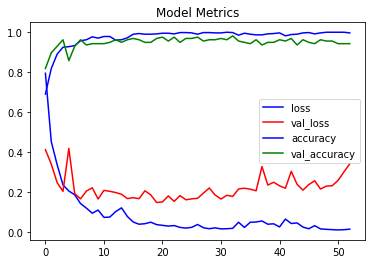

In [3]:
import keras
import pandas as pd
from keras import layers, Sequential
import argparse
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os
from keras import regularizers
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau


# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--dataset", type=str, required=True,
#                 help="path to csv Data")

# ap.add_argument("-o", "--save", type=str, required=True,
#                 help="path to save .h5 model, eg: dir/model.h5")

# args = vars(ap.parse_args())
path_csv = "train_data_final_angle.csv"
path_to_save = "model.h5"

# Load .csv Data
df = pd.read_csv(path_csv)
class_list = df['Pose_Class'].unique()
class_list = sorted(class_list)
class_number = len(class_list)

# Create training and validation splits
x = df.copy()
y = x.pop('Pose_Class')
y, _ = y.factorize()
x = x.astype('float64')
y = keras.utils.to_categorical(y)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    random_state=0)

print('[INFO] Loaded csv Dataset')

model = Sequential([
    layers.Dense(512, activation='relu', input_shape=[x_train.shape[1]]),
    layers.Dense(256, activation='relu'),
    layers.Dense(class_number, activation="softmax")
])









# Model Summary
print('Model Summary: ', model.summary())

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = path_to_save
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)

print('[INFO] Model Training Started ...')
# Start training
history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, earlystopping])






print('[INFO] Model Training Completed')
print(f'[INFO] Model Successfully Saved in /{path_to_save}')

# Plot History
metric_loss = history.history['loss']
metric_val_loss = history.history['val_loss']
metric_accuracy = history.history['accuracy']
metric_val_accuracy = history.history['val_accuracy']

# Construct a range object which will be used as x-axis (horizontal plane) of the graph.
epochs = range(len(metric_loss))

# Plot the Graph.
plt.plot(epochs, metric_loss, 'blue', label=metric_loss)
plt.plot(epochs, metric_val_loss, 'red', label=metric_val_loss)
plt.plot(epochs, metric_accuracy, 'blue', label=metric_accuracy)
plt.plot(epochs, metric_val_accuracy, 'green', label=metric_val_accuracy)

# Add title to the plot.
plt.title(str('Model Metrics'))

# Add legend to the plot.
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# If the plot already exist, remove
plot_png = os.path.exists('metrics.png')
if plot_png:
    os.remove('metrics.png')
    plt.savefig('metrics.png', bbox_inches='tight')
else:
    plt.savefig('metrics.png', bbox_inches='tight')
print('[INFO] Successfully Saved metrics.png')

In [4]:
# Calculate accuracy as a percentage
accuracy = history.history['accuracy'][-1] * 100  # Last accuracy value in the history

# Print the accuracy
print(f'Training Accuracy: {accuracy:.2f}%')

Training Accuracy: 99.51%


In [5]:
# Calculate validation accuracy as a percentage
val_accuracy = history.history['val_accuracy'][-1] * 100  # Last validation accuracy value in the history

# Print the validation accuracy
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Validation Accuracy: 94.12%


<Figure size 432x288 with 0 Axes>

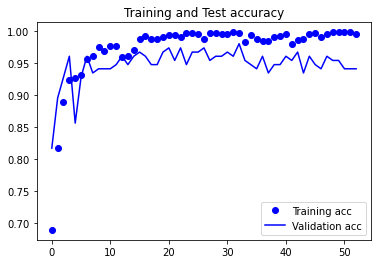

<Figure size 432x288 with 0 Axes>

In [6]:
plt.plot(epochs, metric_accuracy, "bo", label="Training acc")
plt.plot(epochs, metric_val_accuracy, "b", label="Validation acc")
plt.title("Training and Test accuracy")
plt.legend()
plt.figure()

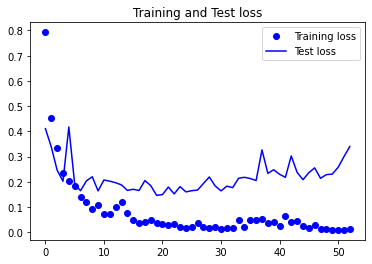

In [7]:
plt.plot(epochs, metric_loss, "bo", label="Training loss")
plt.plot(epochs, metric_val_loss, "b", label="Test loss")
plt.title("Training and Test loss")
plt.legend()
plt.show()


In [9]:
from keras.models import load_model

source = 'dataset/test/plank/00000002.jpg'
path_saved_model = 'model.h5'
threshold =  0.75
save = 'save'
##############
torso_size_multiplier = 2.5
n_landmarks = 33
n_dimensions = 3
landmark_names = [
    'nose',
    'left_eye_inner', 'left_eye', 'left_eye_outer',
    'right_eye_inner', 'right_eye', 'right_eye_outer',
    'left_ear', 'right_ear',
    'mouth_left', 'mouth_right',
    'left_shoulder', 'right_shoulder',
    'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist',
    'left_pinky_1', 'right_pinky_1',
    'left_index_1', 'right_index_1',
    'left_thumb_2', 'right_thumb_2',
    'left_hip', 'right_hip',
    'left_knee', 'right_knee',
    'left_ankle', 'right_ankle',
    'left_heel', 'right_heel',
    'left_foot_index', 'right_foot_index',
]
class_names = [
    'plank', 'goddess', 'downdog',
    'Tree', 'Warrior2'
]
##############

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5,min_tracking_confidence=0.5, model_complexity=2)

col_names = []
for i in range(n_landmarks):
    name = mp_pose.PoseLandmark(i).name
    name_x = name + '_X'
    name_y = name + '_Y'
    name_z = name + '_Z'
    name_v = name + '_V'
    col_names.append(name_x)
    col_names.append(name_y)
    col_names.append(name_z)
    col_names.append(name_v)

# Load saved model
model = load_model(path_saved_model, compile=True)

if source.endswith(('.jpg', '.jpeg', '.png')):
    path_to_img = source
    # Load sample Image
    img = cv2.imread(path_to_img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = pose.process(img_rgb)
    if result.pose_landmarks:
        lm_list = []
        for landmarks in result.pose_landmarks.landmark:
            # Preprocessing
            max_distance = 0
            lm_list.append(landmarks)
        center_x = (lm_list[landmark_names.index('right_hip')].x +
                    lm_list[landmark_names.index('left_hip')].x)*0.5
        center_y = (lm_list[landmark_names.index('right_hip')].y +
                    lm_list[landmark_names.index('left_hip')].y)*0.5

        shoulders_x = (lm_list[landmark_names.index('right_shoulder')].x +
                       lm_list[landmark_names.index('left_shoulder')].x)*0.5
        shoulders_y = (lm_list[landmark_names.index('right_shoulder')].y +
                       lm_list[landmark_names.index('left_shoulder')].y)*0.5

        for lm in lm_list:
            distance = math.sqrt((lm.x - center_x)**2 + (lm.y - center_y)**2)
            if(distance > max_distance):
                max_distance = distance
        torso_size = math.sqrt((shoulders_x - center_x) **
                               2 + (shoulders_y - center_y)**2)
        max_distance = max(torso_size*torso_size_multiplier, max_distance)

        pre_lm = list(np.array([[(landmark.x-center_x)/max_distance, (landmark.y-center_y)/max_distance,
                                 landmark.z/max_distance, landmark.visibility] for landmark in lm_list]).flatten())
        data = pd.DataFrame([pre_lm], columns=col_names)
        predict = model.predict(data)[0]
        if max(predict) > threshold:
            pose_class = class_names[predict.argmax()]
#             pose_class = class_names[np.argmax(predict)]
            print('predictions: ', predict)
            print('predicted Pose Class: ', pose_class)
        else:
            pose_class = 'Unknown Pose'
            print('[INFO] Predictions is below given Confidence!!')

    # Show Result
    img = cv2.putText(
        img, f'{class_names[predict.argmax()]}',
        (40, 50), cv2.FONT_HERSHEY_PLAIN,
        2, (255, 0, 255), 2
    )

    if save:
        os.makedirs('ImageOutput', exist_ok=True)
        img_full_name = os.path.split(path_to_img)[1]
        img_name = os.path.splitext(img_full_name)[0]
        path_to_save_img = f'ImageOutput/{img_name}.jpg'
        cv2.imwrite(f'{path_to_save_img}', img)
        print(f'[INFO] Output Image Saved in {path_to_save_img}')

    cv2.imshow('Output Image', img)
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
    print('[INFO] Inference on Test Image is Ended...')

else:
    # Web-cam
    if source.isnumeric():
        source = int(source)

    cap = cv2.VideoCapture(source)
    source_width = int(cap.get(3))
    source_height = int(cap.get(4))

    # Write Video
    if save:
        out_video = cv2.VideoWriter('output.avi', 
                            cv2.VideoWriter_fourcc(*'MJPG'),
                            10, (source_width, source_height))

    while True:
        success, img = cap.read()
        if not success:
            print('[ERROR] Failed to Read Video feed')
            break
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result = pose.process(img_rgb)

        if result.pose_landmarks:
            lm_list = []
            for landmarks in result.pose_landmarks.landmark:
                # Preprocessing
                max_distance = 0
                lm_list.append(landmarks)
            center_x = (lm_list[landmark_names.index('right_hip')].x +
                        lm_list[landmark_names.index('left_hip')].x)*0.5
            center_y = (lm_list[landmark_names.index('right_hip')].y +
                        lm_list[landmark_names.index('left_hip')].y)*0.5

            shoulders_x = (lm_list[landmark_names.index('right_shoulder')].x +
                           lm_list[landmark_names.index('left_shoulder')].x)*0.5
            shoulders_y = (lm_list[landmark_names.index('right_shoulder')].y +
                           lm_list[landmark_names.index('left_shoulder')].y)*0.5

            for lm in lm_list:
                distance = math.sqrt((lm.x - center_x) **
                                     2 + (lm.y - center_y)**2)
                if(distance > max_distance):
                    max_distance = distance
            torso_size = math.sqrt((shoulders_x - center_x) **
                                   2 + (shoulders_y - center_y)**2)
            max_distance = max(torso_size*torso_size_multiplier, max_distance)

            pre_lm = list(np.array([[(landmark.x-center_x)/max_distance, (landmark.y-center_y)/max_distance,
                                     landmark.z/max_distance, landmark.visibility] for landmark in lm_list]).flatten())
            data = pd.DataFrame([pre_lm], columns=col_names)
            predict = model.predict(data)[0]
            if max(predict) > threshold:
                pose_class = class_names[predict.argmax()]
#                 pose_class = class_names[np.argmax(predict)]
                print('predictions: ', predict)
                print('predicted Pose Class: ', pose_class)
            else:
                pose_class = 'Unknown Pose'
                print('[INFO] Predictions is below given Confidence!!')

            # Show Result
            img = cv2.putText(
                img, f'{pose_class}',
                (40, 50), cv2.FONT_HERSHEY_PLAIN,
                2, (255, 0, 255), 2
            )
        # Write Video
        if save:
            out_video.write(img)

        cv2.imshow('Output Image', img)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    if save:
        out_video.release()
        print("[INFO] Out video Saved as 'output.avi'")
    cv2.destroyAllWindows()
    print('[INFO] Inference on Videostream is Ended...')

1/1 [==============================] - 0s 82ms/step
predictions:  [3.6998626e-02 2.6561506e-09 9.6298242e-01 1.5749163e-06 1.7369714e-05]
predicted Pose Class:  downdog
[INFO] Output Image Saved in ImageOutput/00000002.jpg
[INFO] Inference on Test Image is Ended...


In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ... (your classification code here)

# Assuming you have the predicted labels in 'y_pred' and the true labels in 'y_true'
cm = confusion_matrix(y_true, y_pred, labels=class_list)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_list, yticklabels=class_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()







NameError: name 'y_true' is not defined

5/5 [==============================] - 0s 3ms/step


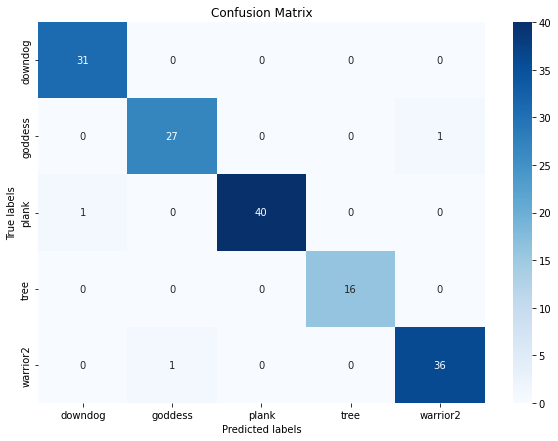

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# ... (previous code)

# Get model predictions for the test data
y_pred = np.argmax(model.predict(x_test), axis=1)

# Convert one-hot encoded y_test back to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_list, yticklabels=class_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [13]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score

# ... (previous code)

# Get the predicted labels for the train and validation sets
y_train_pred = np.argmax(model.predict(x_train), axis=1)
y_val_pred = np.argmax(model.predict(x_test), axis=1)

# Convert one-hot encoded y_train and y_val back to categorical labels
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_test, axis=1)

# Compute accuracy for train and validation sets
train_accuracy = accuracy_score(y_train_labels, y_train_pred)
val_accuracy = accuracy_score(y_val_labels, y_val_pred)

# Compute precision and F1 score for train and validation sets
train_precision = precision_score(y_train_labels, y_train_pred, average='weighted')
val_precision = precision_score(y_val_labels, y_val_pred, average='weighted')

train_f1 = f1_score(y_train_labels, y_train_pred, average='weighted')
val_f1 = f1_score(y_val_labels, y_val_pred, average='weighted')

# Print the metrics
print(f'Train Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')

print(f'Train Precision: {train_precision}')
print(f'Validation Precision: {val_precision}')

print(f'Train F1 Score: {train_f1}')
print(f'Validation F1 Score: {val_f1}')

# ... (rest of the code)


5/5 [==============================] - 0s 2ms/step
Train Accuracy: 0.9934533551554828
Validation Accuracy: 0.9803921568627451
Train Precision: 0.9935583102485315
Validation Precision: 0.9805964052287581
Train F1 Score: 0.9934319843313115
Validation F1 Score: 0.9804036841073878


In [14]:
# Calculate accuracy as a percentage
accuracy = history.history['accuracy'][-1] * 100  # Last accuracy value in the history

# Print the accuracy
print(f'Training Accuracy: {accuracy:.2f}%')


Training Accuracy: 99.51%
